# Getting the Data

In [1]:
def read_data(path):
    import pandas as pd
    import pendulum
    df_logins = pd.read_parquet(path+'/logins.parquet')
    df_payments = pd.read_parquet(path+'/payments.parquet')

    df_payments["datetime"] = pd.to_datetime(df_payments.timestamp, unit='ms')
    df_payments["date"] = df_payments.datetime.dt.date
    df_payments["hour"] = df_payments.datetime.apply(lambda x: x.hour)
    df_payments["week"] = df_payments.datetime.apply(lambda x: x.hour)
    df_payments["month"] = df_payments.datetime.apply(lambda x: x.month)
    df_payments["week_of_month"] = df_payments.datetime.apply(lambda x: pendulum.instance(x).week_of_month)

    df_payments["weekday"] = df_payments.datetime.apply(lambda x: x.weekday())
    df_payments["day_of_week"] = df_payments.datetime.apply(lambda x: x.day_name())
    df_payments["week"] = df_payments.datetime.apply(lambda x: 'Workday' if x.weekday() < 5 else 'Weekend')

    df_payments['chargedback'] = df_payments.chargedback.apply(lambda x: 1 if x else 0)
    df_payments['signal'] = df_payments.chargedback.apply(lambda x: 'SIGNAL' if x else 'NON_SIGNAL')

    df_payments['total_payments_account'] = df_payments.groupby('account_id')['id'].transform('nunique')
    df_payments['total_accounts_device'] = df_payments.groupby('device_id')['account_id'].transform('nunique')
    df_payments['total_installation_device'] = df_payments.groupby('device_id')['installation_id'].transform('nunique')
    df_payments['total_value_account'] = df_payments.groupby('account_id')['value'].transform('sum')

    return df_logins, df_payments

def features_device(df_payments):
    df_device_grp_date = df_payments.groupby(['device_id', 'date']).agg(sum_value_device_day = ('value', 'sum'),
                                                                        n_transaction_device_day = ('id', 'nunique'),
                                                                        n_installation_device_day = ('installation_id', 'nunique'),
                                                                        n_accounts_device_day = ('account_id', 'nunique')).reset_index()
    df_device_grp_date = df_device_grp_date.set_index('date')

    df_device_window_30d = df_device_grp_date.groupby(['device_id'])[['sum_value_device_day', 'n_transaction_device_day', 'n_installation_device_day', 'n_accounts_device_day']].rolling(30, min_periods=0).sum().reset_index()
    
    df_device_window_30d.rename(columns={'sum_value_device_day': 'sum_obs_values_by_device_30d',
                                        'n_transaction_device_day': 'n_obs_transaction_by_device_30d',
                                        'n_installation_device_day': 'n_obs_installation_by_device_30d',
                                        'n_accounts_device_day': 'n_obs_accounts_by_device_30d'}, inplace=True)
    
    df_device_window_15d = df_device_grp_date.groupby(['device_id'])[['sum_value_device_day', 'n_transaction_device_day', 'n_installation_device_day' ,'n_accounts_device_day']].rolling(15, min_periods=0).sum().reset_index()
    df_device_window_15d.rename(columns={'sum_value_device_day': 'sum_obs_values_by_device_15d',
                                        'n_transaction_device_day': 'n_obs_transaction_by_device_15d',
                                        'n_installation_device_day': 'n_obs_installation_by_device_15d',
                                        'n_accounts_device_day': 'n_obs_accounts_by_device_15d'}, inplace=True)

    df_device_window_7d = df_device_grp_date.groupby(['device_id'])[['sum_value_device_day', 'n_transaction_device_day', 'n_installation_device_day', 'n_accounts_device_day']].rolling(7, min_periods=0).sum().reset_index()
    df_device_window_7d.rename(columns={'sum_value_device_day': 'sum_obs_values_by_device_7d',
                                        'n_transaction_device_day': 'n_obs_transaction_by_device_7d',
                                        'n_installation_device_day': 'n_obs_installation_by_device_7d',
                                        'n_accounts_device_day': 'n_obs_accounts_by_device_7d'}, inplace=True)

    df_device = df_device_grp_date.reset_index()[['device_id', 'date']]
    df_device = df_device.merge(df_device_window_30d, on=['device_id', 'date'], how='left')
    df_device = df_device.merge(df_device_window_15d, on=['device_id', 'date'], how='left')
    df_device = df_device.merge(df_device_window_7d, on=['device_id', 'date'], how='left')

    return df_device

def features_installation(df_payments):
    df_installation_grp_date = df_payments.groupby(['installation_id', 'date']).agg(sum_value_installation_day = ('value', 'sum'),
                                                                                    n_transaction_installation_day = ('id', 'nunique')).reset_index()
    df_installation_grp_date = df_installation_grp_date.set_index('date')

    df_installation_window_30d = df_installation_grp_date.groupby(['installation_id'])[['sum_value_installation_day', 'n_transaction_installation_day']].rolling(30, min_periods=0).sum().reset_index()
    
    df_installation_window_30d.rename(columns={'sum_value_installation_day': 'sum_obs_values_by_installation_30d',
                                                'n_transaction_installation_day': 'n_obs_transaction_by_installation_30d'}, inplace=True)
    
    df_installation_window_15d = df_installation_grp_date.groupby(['installation_id'])[['sum_value_installation_day', 'n_transaction_installation_day']].rolling(15, min_periods=0).sum().reset_index()
    df_installation_window_15d.rename(columns={'sum_value_installation_day': 'sum_obs_values_by_installation_15d',
                                                'n_transaction_installation_day': 'n_obs_transaction_by_installation_15d'}, inplace=True)

    df_installation_window_7d = df_installation_grp_date.groupby(['installation_id'])[['sum_value_installation_day',  'n_transaction_installation_day']].rolling(7, min_periods=0).sum().reset_index()
    df_installation_window_7d.rename(columns={'sum_value_installation_day': 'sum_obs_values_by_installation_7d',
                                                'n_transaction_installation_day': 'n_obs_transaction_by_installation_7d'}, inplace=True)

    df_installation = df_installation_grp_date.reset_index()[['installation_id', 'date']]
    df_installation = df_installation.merge(df_installation_window_30d, on=['installation_id', 'date'], how='left')
    df_installation = df_installation.merge(df_installation_window_15d, on=['installation_id', 'date'], how='left')
    df_installation = df_installation.merge(df_installation_window_7d, on=['installation_id', 'date'], how='left')

    return df_installation

def features_account(df_payments):
    df_account_grp_date = df_payments.groupby(['account_id', 'date']).agg(sum_value_account_day = ('value', 'sum'),
                                                                            n_transaction_account_day = ('id', 'nunique'),
                                                                            n_devices_account_day = ('device_id', 'nunique'),
                                                                            n_installation_account_day = ('installation_id', 'nunique')).reset_index()
    
    df_account_grp_date = df_account_grp_date.set_index('date')

    df_account_window_30d = df_account_grp_date.groupby(['account_id'])[['sum_value_account_day', 'n_transaction_account_day' , 'n_devices_account_day', 'n_installation_account_day']].rolling(30, min_periods=0).sum().reset_index()
    
    df_account_window_30d.rename(columns={'sum_value_account_day': 'sum_obs_values_by_account_30d',
                                            'n_transaction_account_day': 'n_obs_transaction_by_account_30d',
                                            'n_devices_account_day': 'n_obs_devices_by_account_30d',
                                            'n_installation_account_day': 'n_obs_installation_by_account_30d'}, inplace=True)
    
    df_account_window_15d = df_account_grp_date.groupby(['account_id'])[['sum_value_account_day', 'n_transaction_account_day' , 'n_devices_account_day', 'n_installation_account_day']].rolling(15, min_periods=0).sum().reset_index()
    df_account_window_15d.rename(columns={'sum_value_account_day': 'sum_obs_values_by_account_15d',
                                            'n_transaction_account_day': 'n_obs_transaction_by_account_15d',
                                            'n_devices_account_day': 'n_obs_devices_by_account_15d',
                                            'n_installation_account_day': 'n_obs_installation_by_account_15d'}, inplace=True)

    df_account_window_7d = df_account_grp_date.groupby(['account_id'])[['sum_value_account_day', 'n_transaction_account_day' , 'n_devices_account_day', 'n_installation_account_day']].rolling(7, min_periods=0).sum().reset_index()
    df_account_window_7d.rename(columns={'sum_value_account_day': 'sum_obs_values_by_account_7d',
                                            'n_transaction_account_day': 'n_obs_transaction_by_account_7d',
                                            'n_devices_account_day': 'n_obs_devices_by_account_7d',
                                            'n_installation_account_day': 'n_obs_installation_by_account_7d'}, inplace=True)

    df_account = df_account_grp_date.reset_index()[['account_id', 'date']]
    df_account = df_account.merge(df_account_window_30d, on=['account_id', 'date'], how='left')
    df_account = df_account.merge(df_account_window_15d, on=['account_id', 'date'], how='left')
    df_account = df_account.merge(df_account_window_7d, on=['account_id', 'date'], how='left')

    return df_account

In [2]:
from pycaret.datasets import get_data

_, df_payments = read_data('../../src/data')

df_device = features_device(df_payments)

df_installation = features_installation(df_payments)

df_account = features_account(df_payments)

In [3]:
df_payments.head()

,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,...,week,month,week_of_month,weekday,day_of_week,signal,total_payments_account,total_accounts_device,total_installation_device,total_value_account
0,103262188752,Qg1D8ImiasT1avXL,7MkfhkrM5b0zCXzO,MR8p/uS6dEX1KlLX,1628347177114,6.145809e+09,1.0,111.781008,NaN,NaN,...,Weekend,8,2,5,Saturday,NON_SIGNAL,1,1,1,111.781008
1,103262188753,7oDcXhI2gc9IY/O2,64aUkvZXE0l7rRYB,lkZEByfr7JB81M0z,1631746300532,9.177266e+09,1.0,137.111008,2602.661008,92.811008,...,Workday,9,3,2,Wednesday,NON_SIGNAL,100,1,1,7554.130780
2,103262188754,yCnksj2py9afMuyJ,j9MxfU8zaJSBAJJB,KwB8eOTyu/c1X/vo,1625328607782,1.192803e+10,0.0,145.601008,0.000000,0.000000,...,Weekend,7,1,5,Saturday,NON_SIGNAL,7,1,1,1093.817055
3,103262188755,UdU8Tz5Vaqw4wpCH,GgWDCBqCa09125xz,/7CONsK63eeDR+bg,1626373613876,4.149963e+09,NaN,85.141008,NaN,NaN,...,Workday,7,3,3,Thursday,NON_SIGNAL,12,31281,31976,1006.322094
4,103262188756,zwb2WB1zI75ku8Z0,Hulxshcopdyf7gaA,qrvdkJ49Ej/kCgdu,1625593458071,1.558110e+08,1.0,189.251008,NaN,NaN,...,Workday,7,2,1,Tuesday,NON_SIGNAL,3,1,1,759.143023


In [4]:
df_device.head()

,device_id,date,sum_obs_values_by_device_30d,n_obs_transaction_by_device_30d,n_obs_installation_by_device_30d,n_obs_accounts_by_device_30d,sum_obs_values_by_device_15d,n_obs_transaction_by_device_15d,n_obs_installation_by_device_15d,n_obs_accounts_by_device_15d,sum_obs_values_by_device_7d,n_obs_transaction_by_device_7d,n_obs_installation_by_device_7d,n_obs_accounts_by_device_7d
0,++25QbwSBgKAXIMZ,2021-05-16,47.061008,1.0,1.0,1.0,47.061008,1.0,1.0,1.0,47.061008,1.0,1.0,1.0
1,++25QbwSBgKAXIMZ,2021-05-17,79.262016,2.0,2.0,2.0,79.262016,2.0,2.0,2.0,79.262016,2.0,2.0,2.0
2,++25QbwSBgKAXIMZ,2021-06-02,125.723023,3.0,3.0,3.0,125.723023,3.0,3.0,3.0,125.723023,3.0,3.0,3.0
3,++25QbwSBgKAXIMZ,2021-07-03,185.584031,4.0,4.0,4.0,185.584031,4.0,4.0,4.0,185.584031,4.0,4.0,4.0
4,++25QbwSBgKAXIMZ,2021-09-02,234.305039,5.0,5.0,5.0,234.305039,5.0,5.0,5.0,234.305039,5.0,5.0,5.0


In [5]:
df_installation.head()

,installation_id,date,sum_obs_values_by_installation_30d,n_obs_transaction_by_installation_30d,sum_obs_values_by_installation_15d,n_obs_transaction_by_installation_15d,sum_obs_values_by_installation_7d,n_obs_transaction_by_installation_7d
0,++0mtz4Q+8+obP7n,2021-05-02,11.181008,1.0,11.181008,1.0,11.181008,1.0
1,++0mtz4Q+8+obP7n,2021-05-16,25.362016,2.0,25.362016,2.0,25.362016,2.0
2,++0uHfkOEeR27PpF,2021-06-19,78.701008,1.0,78.701008,1.0,78.701008,1.0
3,++0uHfkOEeR27PpF,2021-07-03,203.492016,2.0,203.492016,2.0,203.492016,2.0
4,++0uHfkOEeR27PpF,2021-07-10,264.173023,3.0,264.173023,3.0,264.173023,3.0


In [6]:
df_account.head()

,account_id,date,sum_obs_values_by_account_30d,n_obs_transaction_by_account_30d,n_obs_devices_by_account_30d,n_obs_installation_by_account_30d,sum_obs_values_by_account_15d,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d
0,+++F5JdXBfV96KZ6,2021-09-20,98.001008,1.0,1.0,1.0,98.001008,1.0,1.0,1.0,98.001008,1.0,1.0,1.0
1,++1OYxeEe7SiKZkJ,2021-05-20,58.681008,1.0,1.0,1.0,58.681008,1.0,1.0,1.0,58.681008,1.0,1.0,1.0
2,++1OYxeEe7SiKZkJ,2021-05-22,121.622016,2.0,2.0,2.0,121.622016,2.0,2.0,2.0,121.622016,2.0,2.0,2.0
3,++1OYxeEe7SiKZkJ,2021-05-23,176.413023,3.0,3.0,3.0,176.413023,3.0,3.0,3.0,176.413023,3.0,3.0,3.0
4,++1OYxeEe7SiKZkJ,2021-06-19,254.354031,4.0,4.0,4.0,254.354031,4.0,4.0,4.0,254.354031,4.0,4.0,4.0


In [7]:
dataset = df_payments.merge(df_device, on=['device_id', 'date'], how='left')
dataset = dataset.merge(df_installation, on=['installation_id', 'date'], how='left')
dataset = dataset.merge(df_account, on=['account_id', 'date'], how='left')

In [8]:
dataset.head()

,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,...,n_obs_devices_by_account_30d,n_obs_installation_by_account_30d,sum_obs_values_by_account_15d,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d
0,103262188752,Qg1D8ImiasT1avXL,7MkfhkrM5b0zCXzO,MR8p/uS6dEX1KlLX,1628347177114,6.145809e+09,1.0,111.781008,NaN,NaN,...,1.0,1.0,111.781008,1.0,1.0,1.0,111.781008,1.0,1.0,1.0
1,103262188753,7oDcXhI2gc9IY/O2,64aUkvZXE0l7rRYB,lkZEByfr7JB81M0z,1631746300532,9.177266e+09,1.0,137.111008,2602.661008,92.811008,...,30.0,30.0,2167.666203,26.0,15.0,15.0,1017.301086,11.0,7.0,7.0
2,103262188754,yCnksj2py9afMuyJ,j9MxfU8zaJSBAJJB,KwB8eOTyu/c1X/vo,1625328607782,1.192803e+10,0.0,145.601008,0.000000,0.000000,...,2.0,2.0,312.622016,2.0,2.0,2.0,312.622016,2.0,2.0,2.0
3,103262188755,UdU8Tz5Vaqw4wpCH,GgWDCBqCa09125xz,/7CONsK63eeDR+bg,1626373613876,4.149963e+09,NaN,85.141008,NaN,NaN,...,2.0,2.0,143.072016,2.0,2.0,2.0,143.072016,2.0,2.0,2.0
4,103262188756,zwb2WB1zI75ku8Z0,Hulxshcopdyf7gaA,qrvdkJ49Ej/kCgdu,1625593458071,1.558110e+08,1.0,189.251008,NaN,NaN,...,1.0,1.0,189.251008,1.0,1.0,1.0,189.251008,1.0,1.0,1.0


In [9]:
dataset.shape

(648173, 59)

In [10]:
dataset.columns

Index(['id', 'account_id', 'device_id', 'installation_id', 'timestamp',
       'device_age_ms', 'n_accounts_by_device_30d', 'value',
       'sum_values_by_device_30d', 'sum_values_by_device_3d',
       'sum_values_by_installation_30d', 'sum_values_by_installation_3d',
       'low_geo_chargeback_rate_30d', 'medium_geo_chargeback_rate_30d',
       'high_geo_chargeback_rate_30d', 'chargedback', 'datetime', 'date',
       'hour', 'week', 'month', 'week_of_month', 'weekday', 'day_of_week',
       'signal', 'total_payments_account', 'total_accounts_device',
       'total_installation_device', 'total_value_account',
       'sum_obs_values_by_device_30d', 'n_obs_transaction_by_device_30d',
       'n_obs_installation_by_device_30d', 'n_obs_accounts_by_device_30d',
       'sum_obs_values_by_device_15d', 'n_obs_transaction_by_device_15d',
       'n_obs_installation_by_device_15d', 'n_obs_accounts_by_device_15d',
       'sum_obs_values_by_device_7d', 'n_obs_transaction_by_device_7d',
       'n_obs

In [11]:
TARGET = 'chargedback'
KEYS = ['id', 'account_id', 'device_id', 'installation_id', 'timestamp', 'datetime', 'date',
       'hour', 'week', 'month', 'week_of_month', 'weekday', 'day_of_week',
       'signal', 'total_payments_account', 'total_accounts_device',
       'total_installation_device', 'total_value_account']

NUMERIC_FEA = list(set(dataset.columns)-set(KEYS)-set([TARGET]))

IGNORE_FEA  = set(dataset.columns)-set(NUMERIC_FEA)-set([TARGET])

print(NUMERIC_FEA)

['n_obs_transaction_by_device_30d', 'sum_values_by_device_30d', 'low_geo_chargeback_rate_30d', 'sum_values_by_installation_3d', 'n_obs_transaction_by_device_15d', 'n_obs_installation_by_account_30d', 'sum_obs_values_by_device_15d', 'n_obs_transaction_by_device_7d', 'n_obs_transaction_by_account_15d', 'sum_obs_values_by_installation_15d', 'sum_obs_values_by_device_7d', 'sum_obs_values_by_account_7d', 'sum_obs_values_by_device_30d', 'n_obs_transaction_by_account_30d', 'sum_values_by_device_3d', 'n_accounts_by_device_30d', 'sum_values_by_installation_30d', 'n_obs_accounts_by_device_7d', 'n_obs_transaction_by_account_7d', 'n_obs_devices_by_account_7d', 'sum_obs_values_by_account_30d', 'device_age_ms', 'value', 'sum_obs_values_by_installation_30d', 'n_obs_installation_by_device_7d', 'n_obs_transaction_by_installation_7d', 'high_geo_chargeback_rate_30d', 'medium_geo_chargeback_rate_30d', 'sum_obs_values_by_installation_7d', 'n_obs_devices_by_account_30d', 'n_obs_devices_by_account_15d', 'n_o

In [12]:
data = dataset.sample(frac=0.80, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (518538, 59)
Unseen Data For Predictions: (129635, 59)


# Initializing Setup

In [13]:
from pycaret.classification import *

In [14]:
exp_clf101 = setup(data = data,
                   target = TARGET,
                   numeric_features=NUMERIC_FEA,
                   ignore_features=IGNORE_FEA,
                   session_id = 123,
                   log_plots=False,
                   use_gpu = True,
                   )

,Description,Value
0,Session id,123
1,Target,chargedback
2,Target type,Binary
3,Original data shape,"(518538, 59)"
4,Transformed data shape,"(518538, 41)"
5,Transformed train set shape,"(362976, 41)"
6,Transformed test set shape,"(155562, 41)"
7,Ignore features,18
8,Numeric features,40
9,Rows with missing values,38.4%


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [15]:
models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


# Compare Models

In [16]:
best_model = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.4410,0.8102,0.9401,0.0085,0.0169,0.0068,0.0544,0.8420
lda,Linear Discriminant Analysis,0.9869,0.9387,0.3967,0.1685,0.2365,0.2309,0.2528,1.5050
dt,Decision Tree Classifier,0.9924,0.6439,0.2919,0.2696,0.2800,0.2762,0.2766,9.9300
et,Extra Trees Classifier,0.9950,0.8690,0.2639,0.5128,0.3481,0.3458,0.3654,4.5750
rf,Random Forest Classifier,0.9952,0.9101,0.2159,0.5912,0.3154,0.3135,0.3548,8.4010
xgboost,Extreme Gradient Boosting,0.9951,0.9601,0.1263,0.5809,0.2071,0.2057,0.2689,0.7210
lightgbm,Light Gradient Boosting Machine,0.9930,0.9495,0.1171,0.1977,0.1458,0.1425,0.1481,1.0770
ada,Ada Boost Classifier,0.9941,0.9504,0.0653,0.2267,0.1005,0.0985,0.1185,34.6690
catboost,CatBoost Classifier,0.9950,0.9616,0.0631,0.6193,0.1142,0.1134,0.1958,3.9920
gbc,Gradient Boosting Classifier,0.9949,0.9501,0.0356,0.5370,0.0666,0.0660,0.1364,173.5510


In [17]:
print(best_model)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


# Create Model

In [18]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9953,0.9278,0.2216,0.6029,0.3241,0.3223,0.3637
1,0.9949,0.9100,0.1622,0.5085,0.2459,0.2440,0.2852
2,0.9953,0.8980,0.2270,0.5915,0.3281,0.3262,0.3646
3,0.9951,0.9015,0.1667,0.5636,0.2573,0.2555,0.3047
4,0.9952,0.9295,0.2473,0.5823,0.3472,0.3452,0.3775
5,0.9955,0.8847,0.2366,0.6875,0.3520,0.3503,0.4017
6,0.9955,0.9078,0.2595,0.6486,0.3707,0.3688,0.4085
7,0.9952,0.9080,0.2162,0.5634,0.3125,0.3106,0.3471
8,0.9948,0.9268,0.2000,0.4684,0.2803,0.2781,0.3038


In [19]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9924,0.6305,0.2649,0.2593,0.2620,0.2582,0.2582
1,0.9924,0.6332,0.2703,0.2604,0.2653,0.2614,0.2615
2,0.9929,0.6657,0.3351,0.3147,0.3246,0.3210,0.3212
3,0.9926,0.6165,0.2366,0.2573,0.2465,0.2428,0.2430
4,0.9925,0.6566,0.3172,0.2878,0.3018,0.2980,0.2984
5,0.9924,0.6699,0.3441,0.2949,0.3176,0.3138,0.3148
6,0.9919,0.6491,0.3027,0.2523,0.2752,0.2711,0.2723
7,0.9921,0.6331,0.2703,0.2500,0.2597,0.2558,0.2560
8,0.9923,0.6439,0.2919,0.2660,0.2784,0.2745,0.2748


In [20]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9927,0.9577,0.1027,0.1610,0.1254,0.1219,0.1250
1,0.9928,0.9523,0.1027,0.1652,0.1267,0.1232,0.1268
2,0.9933,0.9530,0.1027,0.1959,0.1348,0.1317,0.1387
3,0.9935,0.9595,0.1183,0.2340,0.1571,0.1542,0.1634
4,0.9913,0.9310,0.1290,0.1348,0.1319,0.1275,0.1275
5,0.9925,0.9535,0.0914,0.1393,0.1104,0.1068,0.1092
6,0.9933,0.9296,0.1514,0.2478,0.1879,0.1848,0.1905
7,0.9935,0.9461,0.1243,0.2347,0.1625,0.1596,0.1678
8,0.9936,0.9545,0.0919,0.2125,0.1283,0.1256,0.1369


In [21]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9954,0.9687,0.1459,0.7297,0.2432,0.2420,0.3251
1,0.9950,0.9607,0.0973,0.5625,0.1659,0.1646,0.2325
2,0.9950,0.9634,0.1027,0.5588,0.1735,0.1722,0.2381
3,0.9949,0.9616,0.1183,0.5116,0.1921,0.1906,0.2443
4,0.9950,0.9546,0.1344,0.5435,0.2155,0.2139,0.2686
5,0.9950,0.9556,0.1237,0.5476,0.2018,0.2002,0.2586
6,0.9951,0.9539,0.1351,0.5952,0.2203,0.2188,0.2821
7,0.9952,0.9565,0.1351,0.6098,0.2212,0.2198,0.2855
8,0.9951,0.9627,0.1405,0.5652,0.2251,0.2235,0.2802


In [22]:
qda = create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4370,0.8289,0.9514,0.0085,0.0169,0.0069,0.0554
1,0.4323,0.8020,0.9243,0.0082,0.0163,0.0063,0.0510
2,0.4383,0.8285,0.9514,0.0086,0.0170,0.0069,0.0556
3,0.4429,0.7908,0.9086,0.0083,0.0164,0.0064,0.0502
4,0.4356,0.7951,0.9409,0.0085,0.0168,0.0067,0.0539
5,0.4385,0.8251,0.9677,0.0088,0.0174,0.0073,0.0581
6,0.4511,0.7814,0.9189,0.0085,0.0168,0.0067,0.0526
7,0.4538,0.8031,0.9189,0.0085,0.0169,0.0068,0.0530
8,0.4386,0.8177,0.9514,0.0086,0.0170,0.0069,0.0557


# Tune Model

In [23]:
tuned_rf = tune_model(rf, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8916,0.9608,0.9081,0.0411,0.0787,0.0696,0.1802
1,0.8895,0.9524,0.9189,0.0408,0.0781,0.0691,0.1806
2,0.8967,0.9584,0.9027,0.0428,0.0818,0.0728,0.1839
3,0.8966,0.9594,0.9032,0.0431,0.0822,0.0731,0.1844
4,0.8832,0.9471,0.8656,0.0368,0.0706,0.0614,0.1642
5,0.8926,0.9505,0.8925,0.0410,0.0784,0.0693,0.1781
6,0.8920,0.9407,0.8595,0.0392,0.0750,0.0659,0.1699
7,0.8914,0.9510,0.8973,0.0406,0.0777,0.0686,0.1776
8,0.8915,0.9630,0.9459,0.0426,0.0816,0.0726,0.1882


In [24]:
tuned_dt = tune_model(dt, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9945,0.7399,0.1405,0.3824,0.2055,0.2034,0.2295
1,0.9942,0.6928,0.1297,0.3288,0.1860,0.1837,0.2040
2,0.9942,0.8260,0.1297,0.3333,0.1868,0.1844,0.2055
3,0.9942,0.7414,0.1237,0.3194,0.1783,0.1759,0.1963
4,0.9945,0.7277,0.1344,0.3906,0.2000,0.1979,0.2269
5,0.9945,0.7544,0.1452,0.4091,0.2143,0.2122,0.2415
6,0.9944,0.8385,0.1459,0.3803,0.2109,0.2087,0.2333
7,0.9943,0.7927,0.1459,0.3553,0.2069,0.2045,0.2252
8,0.9944,0.6668,0.1784,0.3976,0.2463,0.2439,0.2639


In [25]:
tuned_lgbm = tune_model(lgbm, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9915,0.8149,0.1784,0.1728,0.1755,0.1712,0.1713
1,0.9853,0.8015,0.1838,0.0819,0.1133,0.1070,0.1160
2,0.9849,0.7680,0.1730,0.0751,0.1047,0.0983,0.1072
3,0.9889,0.7570,0.1667,0.1107,0.1330,0.1277,0.1304
4,0.9884,0.7442,0.2097,0.1250,0.1566,0.1512,0.1563
5,0.9609,0.7956,0.2151,0.0304,0.0533,0.0448,0.0687
6,0.9850,0.7682,0.1892,0.0814,0.1138,0.1075,0.1173
7,0.9842,0.7341,0.2108,0.0833,0.1194,0.1130,0.1256
8,0.9910,0.7918,0.2054,0.1751,0.1891,0.1846,0.1852


In [26]:
tuned_xgb = tune_model(xgb, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9716,0.9625,0.7405,0.1223,0.2100,0.2030,0.2937
1,0.9736,0.9647,0.7676,0.1341,0.2283,0.2215,0.3140
2,0.9744,0.9653,0.7405,0.1346,0.2278,0.2210,0.3089
3,0.9723,0.9648,0.7634,0.1286,0.2202,0.2133,0.3063
4,0.9714,0.9561,0.6882,0.1154,0.1977,0.1906,0.2742
5,0.9733,0.9574,0.7688,0.1338,0.2279,0.2211,0.3139
6,0.9713,0.9565,0.6973,0.1159,0.1988,0.1917,0.2768
7,0.9700,0.9563,0.7514,0.1177,0.2035,0.1964,0.2900
8,0.9718,0.9649,0.7892,0.1292,0.2221,0.2152,0.3124


In [27]:
tuned_qda = tune_model(qda, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5248,0.8941,0.9243,0.0098,0.0194,0.0094,0.0637
1,0.5276,0.8609,0.8865,0.0095,0.0188,0.0088,0.0588
2,0.5252,0.8835,0.9135,0.0097,0.0192,0.0092,0.0623
3,0.5327,0.8479,0.8656,0.0094,0.0186,0.0086,0.0567
4,0.5256,0.8522,0.8978,0.0096,0.0190,0.0090,0.0602
5,0.5315,0.8844,0.9086,0.0099,0.0195,0.0094,0.0627
6,0.5327,0.8419,0.8541,0.0092,0.0183,0.0083,0.0549
7,0.5323,0.8572,0.8865,0.0096,0.0190,0.0090,0.0595
8,0.5261,0.8730,0.9027,0.0096,0.0190,0.0091,0.0609


# Plot Model

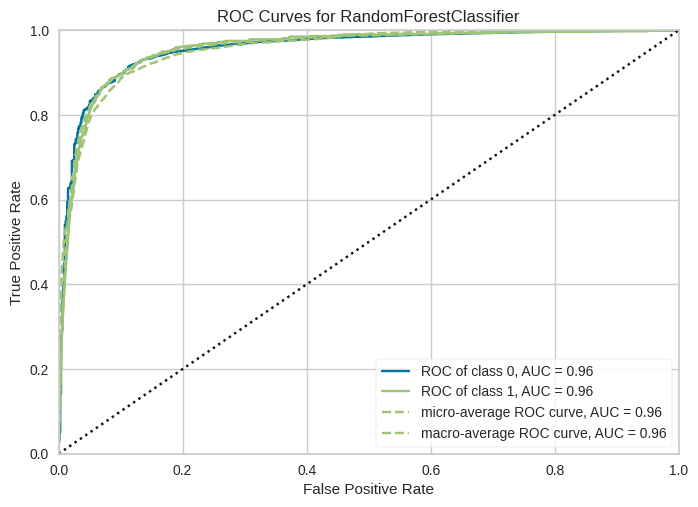

In [28]:
plot_model(tuned_rf, plot = 'auc')

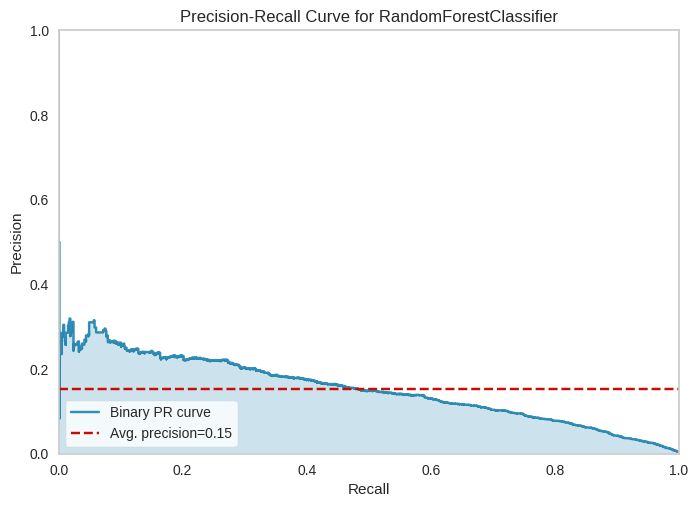

In [29]:
plot_model(tuned_rf, plot = 'pr')

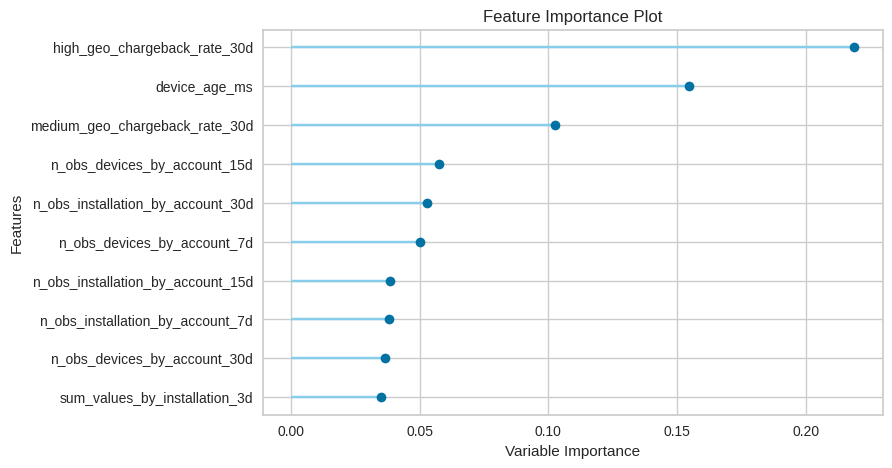

In [30]:
plot_model(tuned_rf, plot='feature')

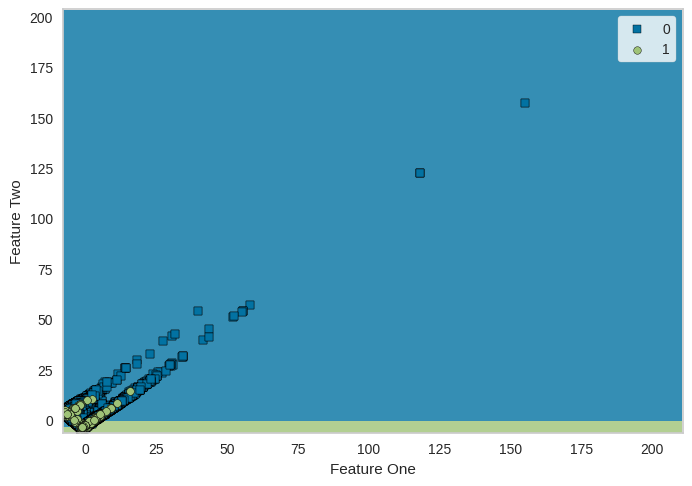

In [31]:
plot_model(tuned_rf, plot='boundary')

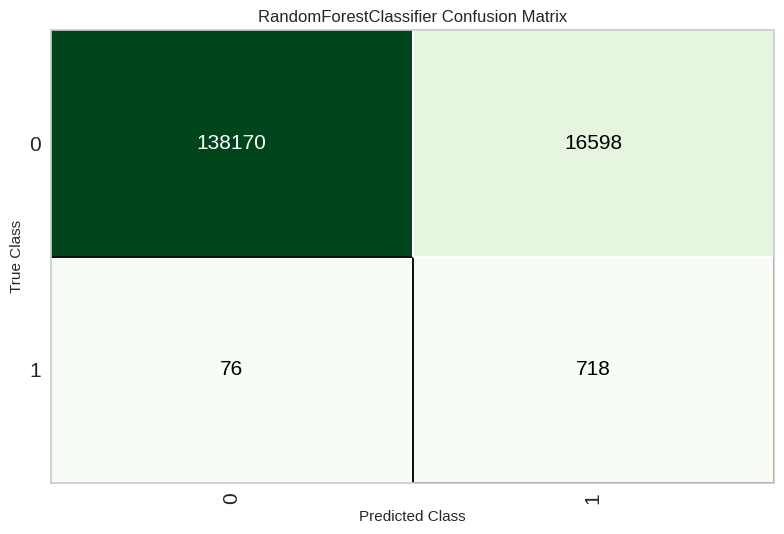

In [32]:
plot_model(tuned_rf, plot = 'confusion_matrix')

# Predict on test / hold-out Sample

In [33]:
pred_holdout = predict_model(tuned_rf)
pred_holdout.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8928,0.9571,0.9043,0.0415,0.0793,0.0702,0.1806


,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,...,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d,chargedback,prediction_label,prediction_score
362976,1.422844e+10,1.0,39.511009,2545.720947,493.161011,2545.720947,493.161011,0.009453,0.0,0.0,...,17.0,15.0,15.0,1008.098083,8.0,7.0,7.0,0,0,0.9312
362977,1.244212e+10,1.0,65.831009,3401.510986,467.701019,3401.510986,467.701019,0.000957,0.0,0.0,...,36.0,15.0,15.0,2410.353271,23.0,7.0,7.0,0,0,0.9467
362978,9.048879e+09,1.0,170.201004,1539.801025,280.111023,1539.801025,280.111023,0.053407,0.0,0.0,...,13.0,10.0,10.0,1161.879028,9.0,7.0,7.0,0,0,0.9210
362979,1.183314e+10,1.0,53.341007,236.151001,0.000000,236.151001,0.000000,0.000000,0.0,0.0,...,14.0,11.0,11.0,565.639099,9.0,7.0,7.0,0,0,0.9542
362980,1.440747e+10,1.0,110.931007,1987.211060,505.721008,1987.211060,505.721008,0.000000,0.0,0.0,...,33.0,13.0,13.0,2290.565186,25.0,7.0,7.0,0,0,0.9207


# Finalize Model

In [34]:
final_rf = finalize_model(tuned_rf)

In [35]:
print(final_rf)

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['n_obs_transaction_by_device_30d',
                                             'sum_values_by_device_30d',
                                             'low_geo_chargeback_rate_30d',
                                             'sum_values_by_installation_3d',
                                             'n_obs_transaction_by_device_15d',
                                             'n_obs_installation_by_account_30d',
                                             'sum_obs_values_by_device_15d',
                                             'n_obs_trans...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight='balanced_subsample',
                                        criterion='gini', max_depth=4,
                                        m

# Predict on unseen data

In [36]:
data_unseen.head()

,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,...,n_obs_devices_by_account_30d,n_obs_installation_by_account_30d,sum_obs_values_by_account_15d,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d
0,103262188757,hodIaEnnqFqEqcY/,XcUQAPZo30oD1/oQ,27WE+mzescXK/yzL,1629491917692,4.229986e+09,1.0,67.421008,1231.581008,0.000000,...,14.0,14.0,1558.466125,16.0,14.0,14.0,890.848062,8.0,7.0,7.0
1,103262188760,ZlxdsvCderVz/uux,cRUeoEqkiIx9xF02,qhSEsGQdo1xP6lGB,1620052517751,4.256864e+07,6.0,38.491008,1030.601008,718.151008,...,1.0,1.0,251.334031,4.0,1.0,1.0,251.334031,4.0,1.0,1.0
2,103262188766,OAuTI2A3TE+pFfdu,S/tJmfFHLUgdWnce,b/hjfWmLlVjG2/Qt,1625486795106,1.237738e+10,1.0,70.291008,547.041008,0.000000,...,11.0,11.0,1799.853101,13.0,11.0,11.0,668.638062,8.0,7.0,7.0
3,103262188767,wK68iCTaFAxEDy68,GgWDCBqCa09125xz,EYUpOEYhQRui96OZ,1631179981651,9.523851e+09,NaN,57.161008,NaN,NaN,...,8.0,8.0,560.308062,8.0,8.0,8.0,508.877055,7.0,7.0,7.0
4,103262188770,5lcc1E7My+p8EGez,2W9pwtAAM68JR5Xx,W89dcqW4R9lfyBjB,1630587794823,1.734079e+10,1.0,106.231008,1407.481008,0.000000,...,30.0,30.0,2578.120156,20.0,15.0,15.0,1289.560078,10.0,7.0,7.0


In [37]:
data_unseen.drop('chargedback', axis = 1, inplace = True)

In [38]:
pred_unseen = predict_model(final_rf, data=data_unseen)
pred_unseen.head()

,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,...,sum_obs_values_by_account_15d,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d,prediction_label,prediction_score
0,4.229986e+09,1.0,67.421005,1231.581055,0.000000,1231.581055,0.0,0.000000,0.000000,0.00000,...,1558.466064,16.0,14.0,14.0,890.848083,8.0,7.0,7.0,0,0.9430
1,4.256864e+07,6.0,38.491009,1030.600952,718.151001,NaN,NaN,0.013331,0.025031,0.31451,...,251.334030,4.0,1.0,1.0,251.334030,4.0,1.0,1.0,1,0.9399
2,1.237738e+10,1.0,70.291008,547.041016,0.000000,547.041016,0.0,0.001068,0.000000,0.00000,...,1799.853149,13.0,11.0,11.0,668.638062,8.0,7.0,7.0,0,0.9493
3,9.523850e+09,NaN,57.161007,NaN,NaN,322.181000,0.0,0.001067,0.000000,0.00000,...,560.308044,8.0,8.0,8.0,508.877045,7.0,7.0,7.0,0,0.9443
4,1.734079e+10,1.0,106.231010,1407.480957,0.000000,1407.480957,0.0,0.000000,0.000000,0.00000,...,2578.120117,20.0,15.0,15.0,1289.560059,10.0,7.0,7.0,0,0.9543


# Save Model

In [39]:
save_model(final_rf,'solution_2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['n_obs_transaction_by_device_30d',
                                              'sum_values_by_device_30d',
                                              'low_geo_chargeback_rate_30d',
                                              'sum_values_by_installation_3d',
                                              'n_obs_transaction_by_device_15d',
                                              'n_obs_installation_by_account_30d',
                                              'sum_obs_values_by_device_15d',
                                              'n_obs_trans...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight='balanced_subsample',
                                         criterion='gini', max_depth=4,
                           

# Load Model

In [40]:
rf_pipeline_from_disk = load_model('solution_2')

Transformation Pipeline and Model Successfully Loaded


In [41]:
new_prediction = predict_model(rf_pipeline_from_disk, data=data_unseen)
new_prediction.head()

,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,...,sum_obs_values_by_account_15d,n_obs_transaction_by_account_15d,n_obs_devices_by_account_15d,n_obs_installation_by_account_15d,sum_obs_values_by_account_7d,n_obs_transaction_by_account_7d,n_obs_devices_by_account_7d,n_obs_installation_by_account_7d,prediction_label,prediction_score
0,4.229986e+09,1.0,67.421005,1231.581055,0.000000,1231.581055,0.0,0.000000,0.000000,0.00000,...,1558.466064,16.0,14.0,14.0,890.848083,8.0,7.0,7.0,0,0.9430
1,4.256864e+07,6.0,38.491009,1030.600952,718.151001,NaN,NaN,0.013331,0.025031,0.31451,...,251.334030,4.0,1.0,1.0,251.334030,4.0,1.0,1.0,1,0.9399
2,1.237738e+10,1.0,70.291008,547.041016,0.000000,547.041016,0.0,0.001068,0.000000,0.00000,...,1799.853149,13.0,11.0,11.0,668.638062,8.0,7.0,7.0,0,0.9493
3,9.523850e+09,NaN,57.161007,NaN,NaN,322.181000,0.0,0.001067,0.000000,0.00000,...,560.308044,8.0,8.0,8.0,508.877045,7.0,7.0,7.0,0,0.9443
4,1.734079e+10,1.0,106.231010,1407.480957,0.000000,1407.480957,0.0,0.000000,0.000000,0.00000,...,2578.120117,20.0,15.0,15.0,1289.560059,10.0,7.0,7.0,0,0.9543
